# Net Surgery

Caffe networks can be transformed to your particular needs by editing the model parameters. The data, diffs, and parameters of a net are all exposed in pycaffe.

Roll up your sleeves for net surgery with pycaffe!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Make sure that caffe is on the python path:
caffe_root = '../caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

../caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
../caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
../caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


## Designer Filters

To show how to load, manipulate, and save parameters we'll design our own filters into a simple network that's only a single convolution layer. This net has two blobs, `data` for the input and `conv` for the convolution output and one parameter `conv` for the convolution filter weights and biases.

blobs ['x', 'y', 'conv_1', 'guess', 'Softmax', 'loss']
params ['conv_1', 'guess']
bike shape: (224, 224, 3)
shape after transpose:  (3, 224, 224)
input shape (1, 3, 224, 224) input type uint8


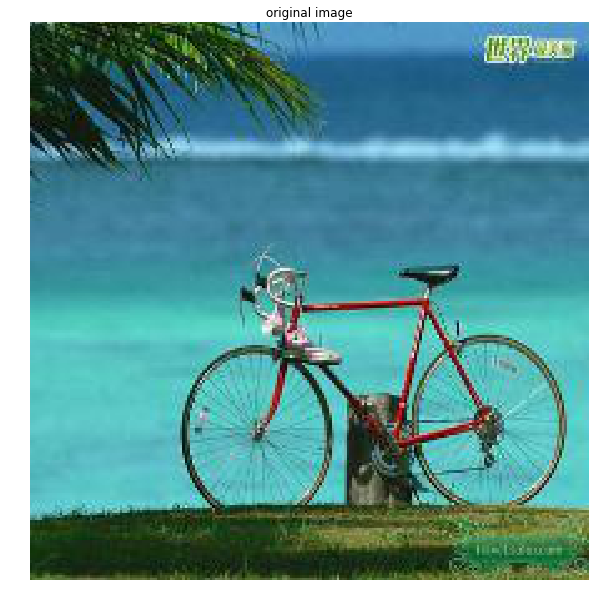

In [2]:
# Load the net, list its data and params, and filter an example image.
caffe.set_mode_cpu()
net = caffe.Net('smallnet.prototxt', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))


# BIKE
im = np.array(Image.open('data/train/img868.png'))
print "bike shape:", im.shape
plt.title("original image")
plt.imshow(im)
plt.axis('off')
im = im.transpose(2,0,1)
print "shape after transpose: ", im.shape
im_input = im[np.newaxis, :, :]
"""

# CAT
im = np.array(Image.open('../caffe/examples/images/cat_gray.jpg'))
im_input = im[np.newaxis, np.newaxis, :, :]
plt.title("original image")
plt.imshow(im)
plt.axis('off')
"""
print "input shape", im_input.shape, "input type", im_input.dtype

net.blobs['x'].reshape(*im_input.shape)
net.blobs['x'].data[...] = im_input


The convolution weights are initialized from Gaussian noise while the biases are initialized to zero. These random filters give output somewhat like edge detections.

-0.38 0.372448


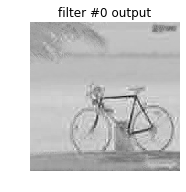

In [3]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure()
    filt_min, filt_max = net.blobs['conv_1'].data.min(), net.blobs['conv_1'].data.max()
    print filt_min, filt_max
    for i in range(1):
        plt.subplot(1,4,i+2)
        plt.title("filter #{} output".format(i))
        plt.imshow(net.blobs['conv_1'].data[0, i])#, vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

# filter the image with initial 
show_filters(net)

In [4]:
#net.params['conv_1'][1].data[0] = 0.999
#net.params['conv_1'][0].data[0,:,0,0] = [0.0, 1, -1]
print net.params['conv_1'][0].data[0,:,0,0]
print net.params['conv_1'][1].data[0]



[ 0.01366469  0.02405755 -0.05079374]
-0.0601581


(224, 224)
(224, 224)


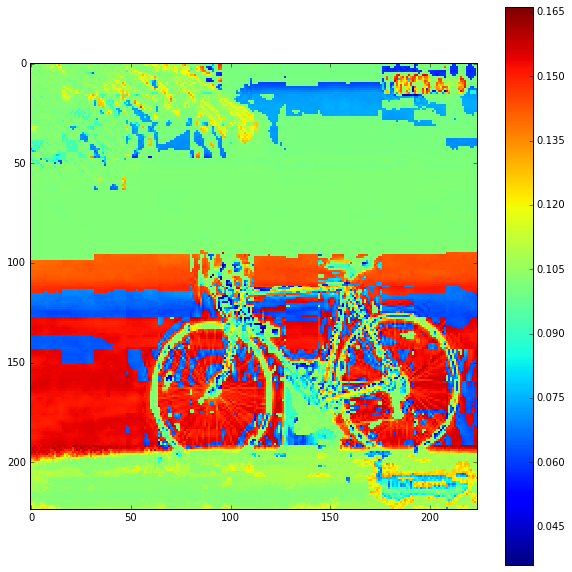

In [30]:
#net.forward()

ans = net.blobs['y'].data[0,0,:,:].astype(int)

[rowsize, colsize] = ans.shape # img, bin, row, col
cols = np.tile(range(colsize), rowsize)
rows = np.repeat(range(rowsize), colsize)


correct_bins = [ans[i,j] for  i in range(rowsize) for j in range(colsize)]
   
guesses = net.blobs['Softmax'].data[0,correct_bins,rows,cols]

#plt.imshow(guesses)
#plt.colorbar()
#plt.show()

print guesses.reshape(224,224).shape
print ans.shape

#print net.blobs['guess'].data[0,:,:,:].shape

#correct_bin = net.blobs['guess'].data[0,ans,:,:]

plt.imshow(guesses.reshape(224,224),cmap='jet')
plt.colorbar()
plt.show()